In [1]:
import numpy as np
import sys
import os
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_cellwise_df_10samplesperfile, extract_noise
from extract_cell_timetrace import extract_cell_timetrace
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
data_path = 'C:/Users/vpming/tuni_ml/data'
df = build_cellwise_df_10samplesperfile(data_path)

In [ ]:
x = np.stack(df['time_trace'])

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3
n_bins = 4
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

# Do NOT scale y for classification!
train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32), 
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [4]:
class CNNClassifier(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * (n_timepoints // 4), 64),
            nn.ReLU(),
            nn.Linear(64, n_classes) 
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        return self.fc(x)  

In [5]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [6]:
def fit(model, train_loader, test_loader, epochs=20):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/cnn_classifier_dtt.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return train_losses, test_losses, train_accs, test_accs, conf_mat

Epoch 5/20 Train Loss: 0.8619  Train Accuracy: 59.40%  Test Loss: 0.9599  Test Accuracy: 54.83%
Epoch 10/20 Train Loss: 0.5983  Train Accuracy: 72.82%  Test Loss: 1.2511  Test Accuracy: 50.02%
Epoch 15/20 Train Loss: 0.2679  Train Accuracy: 89.55%  Test Loss: 2.2933  Test Accuracy: 47.89%
Epoch 20/20 Train Loss: 0.1013  Train Accuracy: 96.61%  Test Loss: 3.8528  Test Accuracy: 47.07%


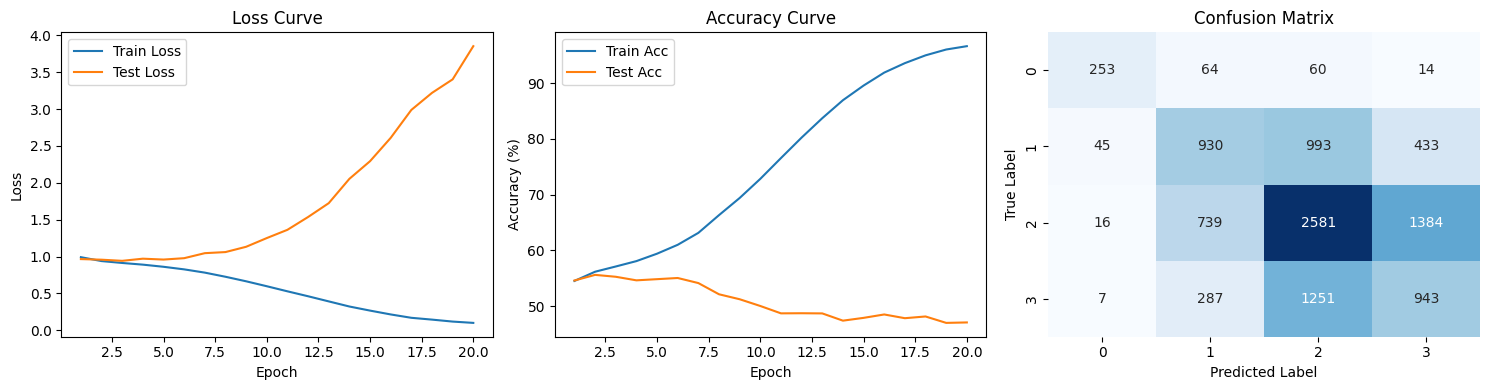

([0.992182686328888,
  0.9392395199775696,
  0.9136128118515014,
  0.8910019743919373,
  0.8619075423240662,
  0.8269203141212463,
  0.7827793230056763,
  0.726713977432251,
  0.6651935012817383,
  0.5983067410945893,
  0.5292841959476471,
  0.46239215586185456,
  0.39271814908981323,
  0.3233387681722641,
  0.267917544054985,
  0.2158705389380455,
  0.1702342331111431,
  0.14568021245598792,
  0.11906087345480919,
  0.10134041328132153],
 [0.9662331339836121,
  0.9579931565284729,
  0.9425903033256531,
  0.971736998462677,
  0.9598970861434937,
  0.9785138931274414,
  1.0465029109954833,
  1.0612821018218994,
  1.1330643648147583,
  1.2510878782272339,
  1.363132788848877,
  1.5367461933135986,
  1.7244156005859375,
  2.0541543529510498,
  2.293282074356079,
  2.609650743484497,
  2.988573091506958,
  3.219544123458862,
  3.4028598724365233,
  3.8528028190612793],
 [54.51,
  56.165,
  57.1025,
  58.0675,
  59.4,
  60.9925,
  63.1325,
  66.315,
  69.3875,
  72.82,
  76.5475,
  80.22,
 

In [7]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = CNNClassifier(n_timepoints, n_classes)

fit(model, train_loader, test_loader)

In [9]:
cell_trace = extract_cell_timetrace('C:/Users/vpming/tuni_ml\data\stim_0.2_beta_0.04_noise_0.02_kcross_0.0050\sim_data__stimMag_0.20_beta_0.40_noise_0.020_kcross_0.0050_nSamples_1000_1.h5', 12)
cell_trace_scaled = x_scaler.transform(cell_trace.reshape(1, -1))
with torch.no_grad():
    logits = model(torch.tensor(cell_trace_scaled, dtype=torch.float32))
    pred_class = logits.argmax(dim=1).item()

print(pred_class)

1



=== Training for noise 0.01 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.7632  Train Accuracy: 63.59%  Test Loss: 0.8553  Test Accuracy: 59.30%
Epoch 10/15 Train Loss: 0.6169  Train Accuracy: 72.20%  Test Loss: 0.9626  Test Accuracy: 57.00%
Epoch 15/15 Train Loss: 0.3866  Train Accuracy: 83.79%  Test Loss: 1.2776  Test Accuracy: 55.60%


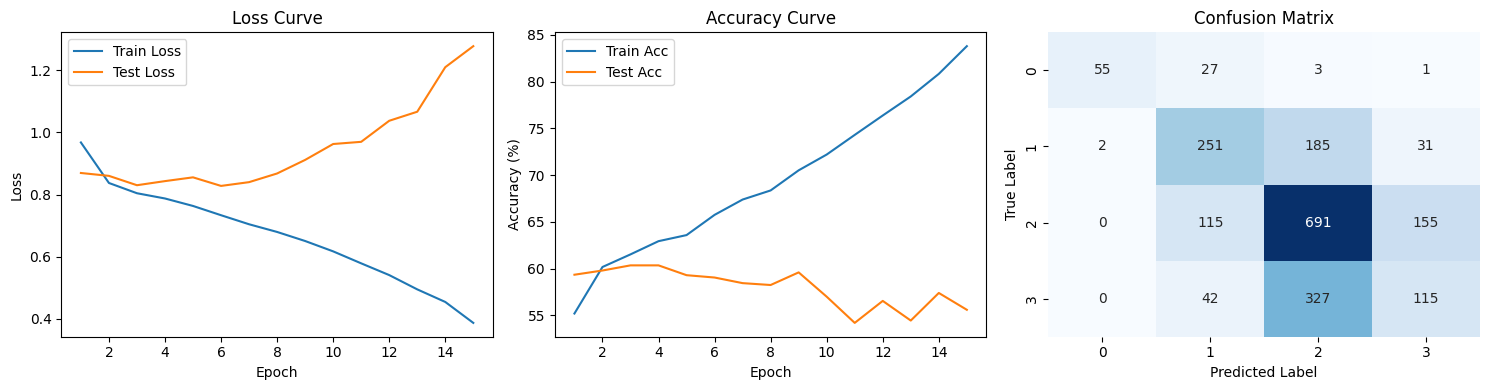


=== Training for noise 0.02 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.8219  Train Accuracy: 61.69%  Test Loss: 0.9232  Test Accuracy: 56.20%
Epoch 10/15 Train Loss: 0.5000  Train Accuracy: 79.12%  Test Loss: 1.2077  Test Accuracy: 50.45%
Epoch 15/15 Train Loss: 0.0786  Train Accuracy: 98.28%  Test Loss: 2.5325  Test Accuracy: 50.10%


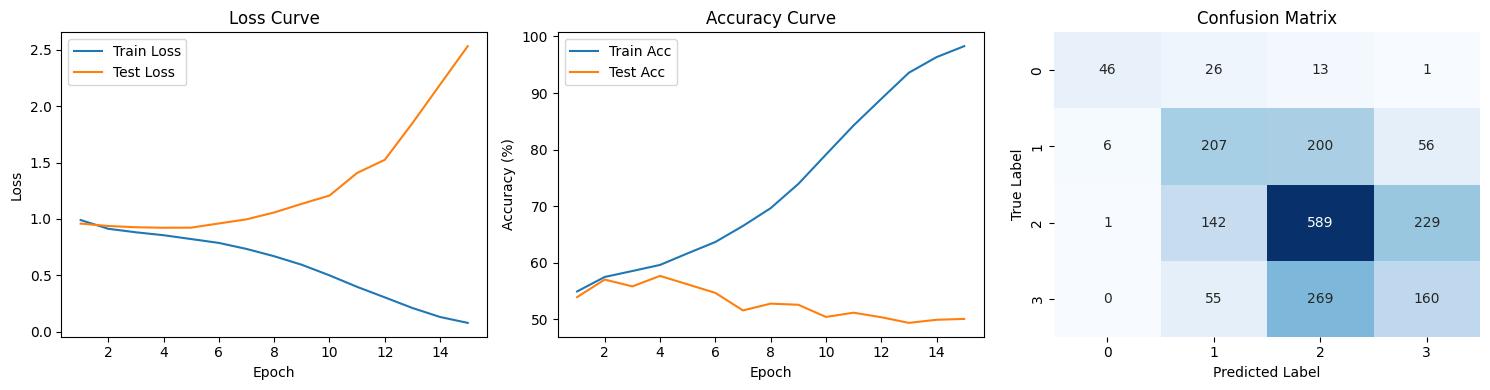


=== Training for noise 0.03 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.8868  Train Accuracy: 58.45%  Test Loss: 0.9711  Test Accuracy: 55.35%
Epoch 10/15 Train Loss: 0.6345  Train Accuracy: 72.41%  Test Loss: 1.2083  Test Accuracy: 52.00%
Epoch 15/15 Train Loss: 0.2324  Train Accuracy: 91.40%  Test Loss: 2.1868  Test Accuracy: 46.90%


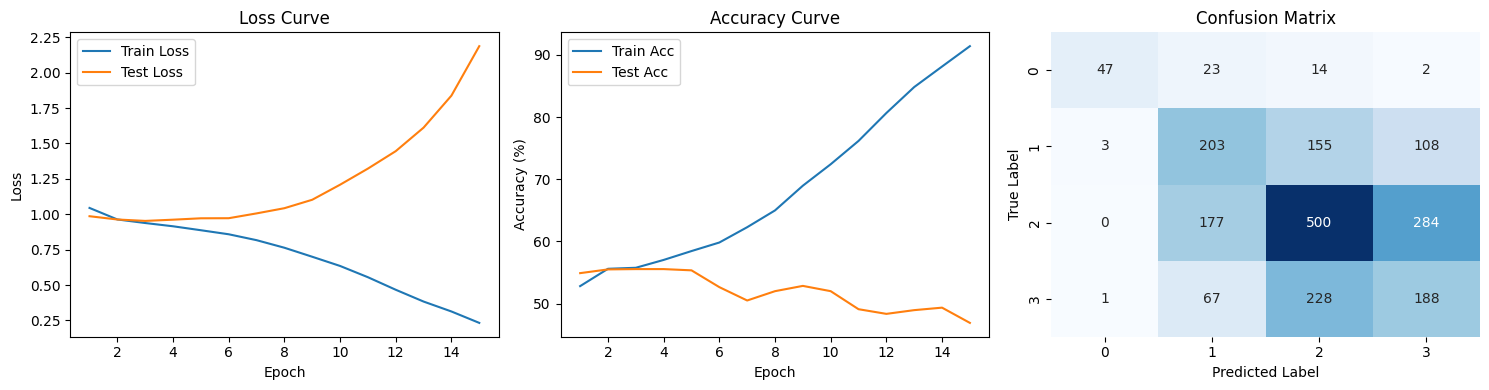


=== Training for noise 0.04 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.9348  Train Accuracy: 56.40%  Test Loss: 1.0513  Test Accuracy: 52.65%
Epoch 10/15 Train Loss: 0.5737  Train Accuracy: 75.94%  Test Loss: 1.3843  Test Accuracy: 44.65%
Epoch 15/15 Train Loss: 0.1070  Train Accuracy: 97.41%  Test Loss: 2.8850  Test Accuracy: 43.60%


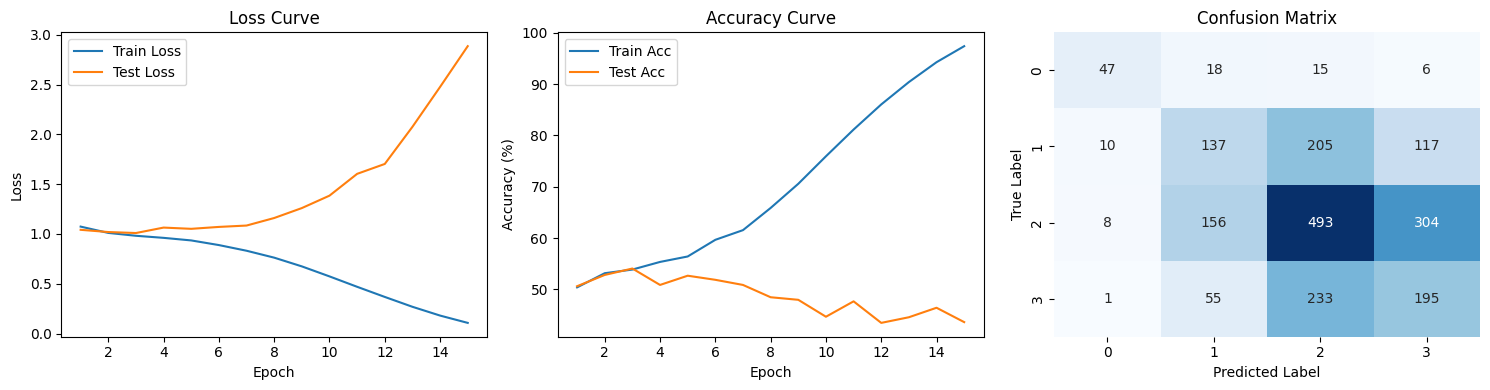


=== Training for noise 0.05 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.9507  Train Accuracy: 56.24%  Test Loss: 1.0712  Test Accuracy: 49.75%
Epoch 10/15 Train Loss: 0.6479  Train Accuracy: 72.28%  Test Loss: 1.3788  Test Accuracy: 48.25%
Epoch 15/15 Train Loss: 0.1632  Train Accuracy: 95.24%  Test Loss: 2.4706  Test Accuracy: 44.15%


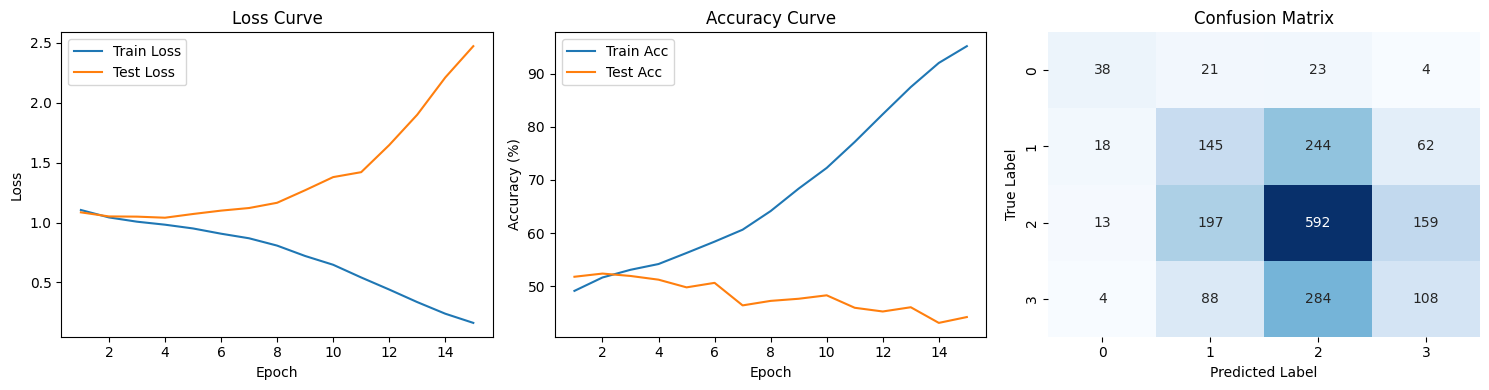

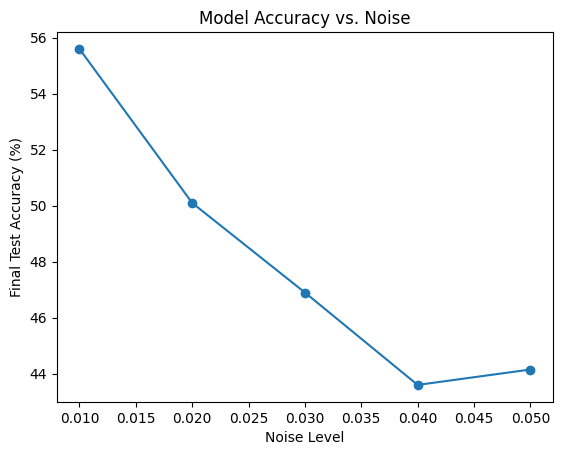

In [ ]:
df['noise'] = df['simulation_file'].apply(extract_noise)

results = []

for noise_level in sorted(df['noise'].unique()):
    print(f'\n=== Training for noise {noise_level} ===')
    mask = df['noise'] == noise_level
    X = np.stack(df.loc[mask, 'time_trace'])
    y = df.loc[mask, 'dis_to_target'].values  

    n_bins = 4
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    y_class = np.digitize(y, bins[1:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Define model for this run
    n_timepoints = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    model = CNNClassifier(n_timepoints, n_classes)

    # Train & evaluate (use your fit function)
    print(f"Training on {X_train.shape[0]} samples; Testing on {X_test.shape[0]} samples")
    train_losses, test_losses, train_accs, test_accs, conf_mat = fit(model, train_loader, test_loader, epochs=15)
    results.append({'noise': noise_level, 'test_acc': test_accs[-1], 'confusion_matrix': conf_mat})

# Plot performance vs. noise
plt.plot([r['noise'] for r in results], [r['test_acc'] for r in results], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Model Accuracy vs. Noise") 
plt.show()